In [1]:
import numpy as np
import pynucastro as pyna
reaclibrary = pyna.ReacLibLibrary()
all_nuclei = ["n","p", "h2", "h3", "he3", "he4","Li6","Li7","Be7"]#,"Li8","B8","Be9","B10","B11","C11","B12","C12","N12","C13","N13","C14","N14","O14","N15","O15","O16"]
bbn_library = reaclibrary.linking_nuclei(all_nuclei)
bbn_network = pyna.networks.PythonNetwork(libraries=bbn_library)


In [2]:
p__n_string = '''
b0 = -0.62173 
b1 = 0.22211e2
b2 = -0.72798e2
b3 = 0.11571e3
b4 = -0.11763e2
b5 = 0.45521e2
b6 = -3.7973 
b7 = 0.41266 
b8 = -0.026210
b9 = 0.87934e-3
b10 = -0.12016e-4
qpn = 2.8602

@numba.njit() 
def p__n(rate_eval, tf):  
    # p --> n
    rate=0
    #rate from https://arxiv.org/pdf/astro-ph/0408076.pdf appendix C
    if tf.T9>1.160451812:
      b=[b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10]
      z=5.92989658*tf.T9i
      for i in range(11):
         rate+=1/880.2*np.exp(-qpn*z)*b[i]*z**-i 
        
    #Kawano rate
    #rate=1/879.6*(5.252/z - 16.229/z**2 + 18.059/z**3 + 34.181/z**4 + 27.617/z**5)*np.exp(-2.530988*z)
    rate_eval.p__n = rate

'''

In [3]:
n__p_string = '''
a0 = 1
a1 = 0.15735 
a2 = 4.6172
a3 = -0.40520e2 
a4 = 0.13875e3 
a5 = -0.59898e2
a6 = 0.66752e2 
a7 = -0.16705e2 
a8 = 3.8071
a9 = -0.39140 
a10 = 0.023590 
a11 = -0.83696e-4
a12 = -0.42095e-4 
a13 = 0.17675e-5
qnp = 0.33979 

@numba.njit()
def n__p(rate_eval, tf):
    # n --> p
    z=5.92989658*tf.T9i
    #rate from https://arxiv.org/pdf/astro-ph/0408076.pdf appendix C
    rate=0
    a=[a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13]
    for i in range(14):
      rate+=1/880.2*np.exp(-qnp/z)*a[i]*z**-i

    #Kawano rate
    #rate = 1/879.6*(0.565/z - 6.382/z**2 + 11.108/z**3 + 36.492/z**4 + 27.512/z**5)

    rate_eval.n__p = rate

'''

In [4]:
class n__p_Rate(pyna.Rate):
    def __init__(self, reactants=None, products=None,
                 r0=1.0, T0=1.0, nu=0):

        # we'll take the Q value just to be the change in binding energy
        Q = 0
        for n in reactants:
            Q += -n.A * n.nucbind
        for n in products:
            Q += n.A * n.nucbind

        # we set the chapter to custom so the network knows how to deal with it
        self.chapter = "custom"
        self.reverse = None
    
        # call the Rate init to do the remaining initialization
        super().__init__(reactants=reactants, products=products, Q=Q)

        self.r0 = r0
        self.T0 = T0
        self.nu = nu

    def function_string_py(self):
        """return a string containing a python function that computes
        the rate"""
        return n__p_string

    def eval(self, T, rhoY=None):
        return self.r0 * (T / self.T0)**self.nu

In [5]:
n__p = n__p_Rate(reactants=[pyna.Nucleus("n")],
                  products=[pyna.Nucleus("p")],
                  r0=1, T0=1, nu=1)

In [6]:
class p__n_Rate(pyna.Rate):
    def __init__(self, reactants=None, products=None,
                 r0=1.0, T0=1.0, nu=0):

        # we'll take the Q value just to be the change in binding energy
        Q = 0
        for n in reactants:
            Q += -n.A * n.nucbind
        for n in products:
            Q += n.A * n.nucbind

        # we set the chapter to custom so the network knows how to deal with it
        self.chapter = "custom"

        self.reverse = None
    
        # call the Rate init to do the remaining initialization
        super().__init__(reactants=reactants, products=products, Q=Q)

        self.r0 = r0
        self.T0 = T0
        self.nu = nu

    def function_string_py(self):
        """return a string containing a python function that computes
        the rate"""
        return p__n_string

    def eval(self, T, rhoY=None):
        return self.r0 * (T / self.T0)**self.nu

In [7]:
p__n = p__n_Rate(reactants=[pyna.Nucleus("p")],
                  products=[pyna.Nucleus("n")],
                  r0=1, T0=1, nu=1)

In [8]:
p__n.fname='p__n'
n__p.fname='n__p'
#print(p__n.function_string_py())

In [9]:
bbn_network.validate(reaclibrary)

validation: missing Li7 + H2 ⟶ p + Li8 as alternative to Li7 + H2 ⟶ n + He4 + He4 (Q = -0.19103 MeV).
validation: missing Li7 + H3 ⟶ H2 + Li8 as alternative to Li7 + H3 ⟶ n + n + He4 + He4 (Q = -4.22462 MeV).
validation: missing Li7 + H3 ⟶ n + Be9 as alternative to Li7 + H3 ⟶ n + n + He4 + He4 (Q = 10.4376 MeV).


True

In [10]:
"""
bbn_library += pyna.Library(rates=[p__n,n__p])
bbn_library.remove_rate(bbn_library.get_rate('n__p__weak__wc12'))
bbn_network = pyna.networks.PythonNetwork(libraries=bbn_library)
"""

"\nbbn_library += pyna.Library(rates=[p__n,n__p])\nbbn_library.remove_rate(bbn_library.get_rate('n__p__weak__wc12'))\nbbn_network = pyna.networks.PythonNetwork(libraries=bbn_library)\n"

In [11]:
rc=pyna.RateCollection(libraries=bbn_library)

In [12]:
bbn_network.find_duplicate_links()

[]

In [13]:
[1.21479701e-01, 8.64513051e-01, 1.19051149e-03, 2.80657172e-05,
       1.66372810e-07, 2.88538225e-03, 3.47258262e-15, 6.86882501e-11,
       2.04770709e-15, 1.80521226e-17, 9.31364335e-18, 1.34103305e-31,
       9.97027146e-23, 1.13066352e-18, 1.13456204e-22, 1.64684923e-26,
       1.36936304e-19, 7.84179203e-21, 1.99560418e-21, 2.72261352e-38,
       3.00232270e-24, 1.74972259e-22, 7.20396785e-25, 9.30339757e-29,
       6.58249629e-28, 1.23116438e-25]

[0.121479701,
 0.864513051,
 0.00119051149,
 2.80657172e-05,
 1.6637281e-07,
 0.00288538225,
 3.47258262e-15,
 6.86882501e-11,
 2.04770709e-15,
 1.80521226e-17,
 9.31364335e-18,
 1.34103305e-31,
 9.97027146e-23,
 1.13066352e-18,
 1.13456204e-22,
 1.64684923e-26,
 1.36936304e-19,
 7.84179203e-21,
 1.99560418e-21,
 2.72261352e-38,
 3.0023227e-24,
 1.74972259e-22,
 7.20396785e-25,
 9.30339757e-29,
 6.58249629e-28,
 1.23116438e-25]

In [14]:
X=np.array([1.21479701e-01, 8.64513051e-01, 2.38102297e-03, 8.41971515e-05,
       4.99118431e-07, 1.15415290e-02, 2.08354957e-14, 4.80817751e-10,
       1.63816567e-14, 1.26364858e-16, 8.38227901e-17, 1.07282644e-30,
       9.97027146e-22, 1.24372987e-17, 1.36147444e-21, 1.81153416e-25,
       1.64323565e-18, 1.01943296e-19, 2.79384585e-20, 3.26713622e-37,
       3.90301951e-23, 2.44961162e-21, 1.08059518e-23, 1.30247566e-27,
       9.87374444e-27, 1.96986301e-24])

In [15]:
all_nuclei = ["n","p", "d", "t", "he3", "he4","li6","li7","be7"]

In [16]:
comp = pyna.Composition(rc.get_nuclei())
for i in range(len(all_nuclei)):

    comp.set_nuc(all_nuclei[i], X[i])


comp.get_molar()

{n: 0.121479701,
 p: 0.864513051,
 d: 0.001190511485,
 t: 2.8065717166666666e-05,
 He3: 1.6637281033333333e-07,
 He4: 0.00288538225,
 Li6: 3.4725826166666667e-15,
 Li7: 6.868825014285714e-11,
 Be7: 2.3402366714285716e-15}

In [48]:
equalcomp=pyna.Composition(rc.get_nuclei())
equalcomp.set_equal()
equalcomp.get_molar()

{n: 0.1111111111111111,
 p: 0.1111111111111111,
 d: 0.05555555555555555,
 t: 0.037037037037037035,
 He3: 0.037037037037037035,
 He4: 0.027777777777777776,
 Li6: 0.018518518518518517,
 Li7: 0.015873015873015872,
 Be7: 0.015873015873015872}

In [17]:
earlyrho=1.6228855793577016e-05
earlyT=9e8

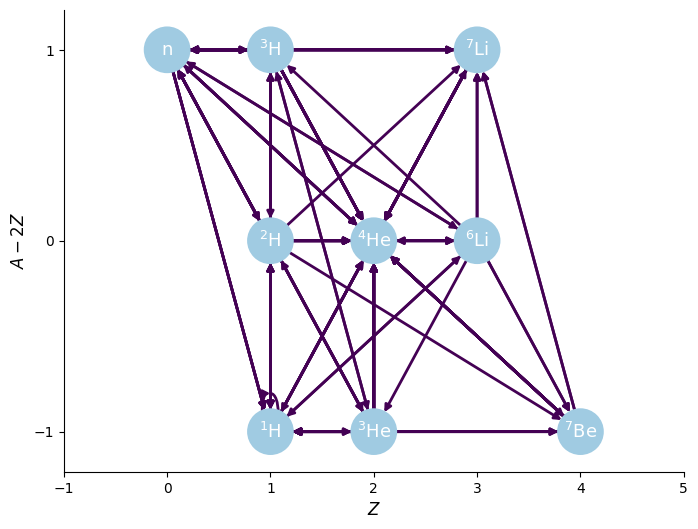

In [18]:
fig = rc.plot(rotated=True, rate_filter_function=lambda r: r.Q > 0)#,curved_edges=True)

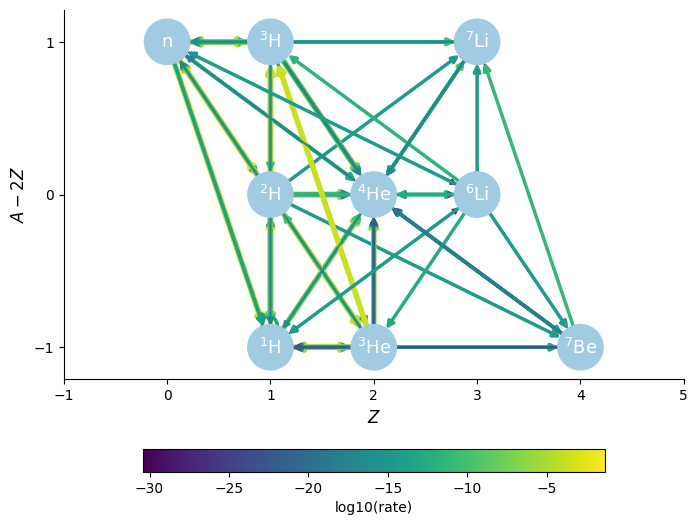

In [20]:

fig = rc.plot(earlyrho, earlyT, comp, rotated=True, rate_filter_function=lambda r: r.Q > 0)


In [21]:
Xlate=np.array([1.89054517e-03, 7.54747250e-01, 1.83842114e-03, 5.21527572e-05,
       1.39415899e-05, 2.41457680e-01, 2.72429091e-12, 8.57969022e-09,
       1.12004875e-13, 2.31435611e-12, 1.60007252e-14, 1.75824359e-26,
       1.24705459e-17, 3.42573469e-15, 7.44591239e-21, 1.42897335e-18,
       5.98301196e-15, 5.29046822e-16, 1.45825240e-16, 6.74449055e-30,
       4.37207532e-18, 1.17309043e-16, 4.59681415e-20, 3.16115275e-21,
       1.82156504e-20, 2.91156094e-19])

latecomp = pyna.Composition(rc.get_nuclei())
for i in range(len(all_nuclei)):

    latecomp.set_nuc(all_nuclei[i], Xlate[i])

laterho=9.464340408557126e-06
lateT=763484805.4296345

latecomp.get_molar()

{n: 0.00189054517,
 p: 0.75474725,
 d: 0.00091921057,
 t: 1.73842524e-05,
 He3: 4.647196633333333e-06,
 He4: 0.06036442,
 Li6: 4.5404848500000003e-13,
 Li7: 1.2256700314285714e-09,
 Be7: 1.600069642857143e-14}

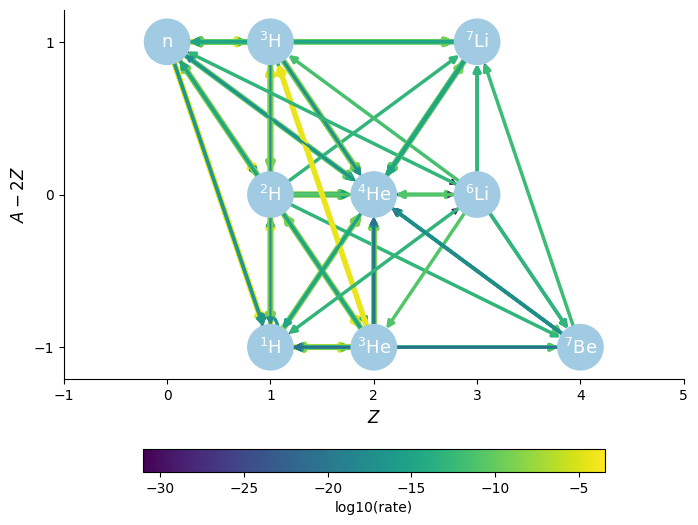

In [22]:
fig = rc.plot(laterho, lateT, latecomp, rotated=True, rate_filter_function=lambda r: r.Q > 0)


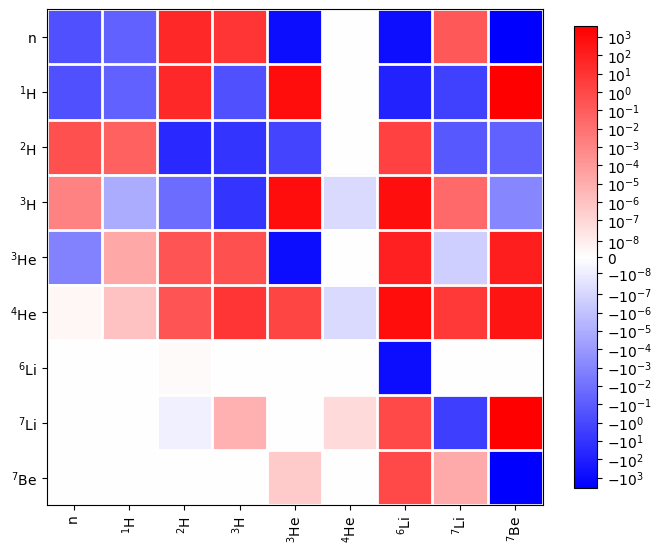

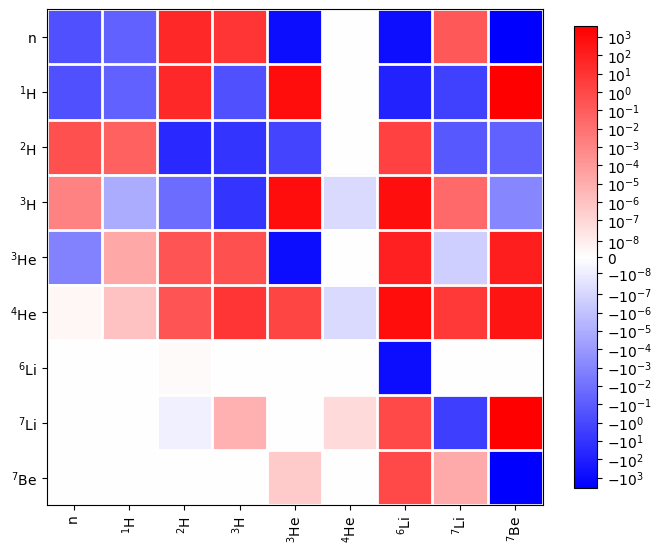

In [40]:
bbn_network.plot_jacobian(earlyrho, earlyT, comp, rate_scaling=3.e11)

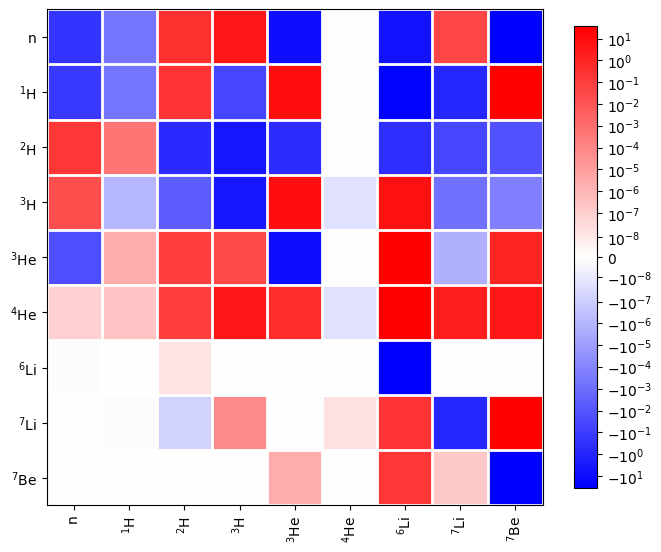

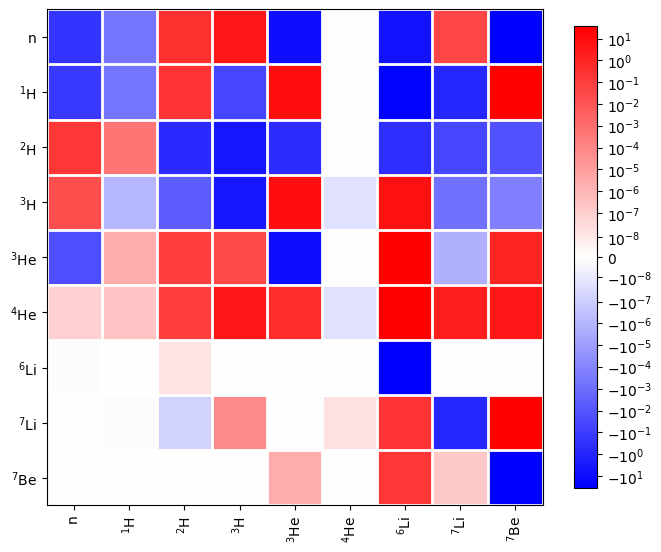

In [43]:
bbn_network.plot_jacobian(laterho, lateT, latecomp, rate_scaling=3.e9)

In [25]:
comp